In [6]:
import numpy as np
import strawberryfields as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# Convert GKP dB -> epsilon
def db_to_epsilon(db_val: float) -> float:
    """
    Convert a given GKP squeezing level in dB to the corresponding epsilon,
    defined via tanh(epsilon) = 10^(-db_val/10).

    For example:
      db_val=10  => tanh(eps)=0.1   => eps ~ 0.100167
      db_val=15  => tanh(eps)=0.0316 => eps ~ 0.032
    """
    t = 10.0 ** (-db_val / 10.0)  # tanh(epsilon) = t
    # epsilon = arctanh(t) = 0.5 * ln((1+t)/(1-t))
    eps = 0.5 * np.log((1.0 + t)/(1.0 - t))
    return eps

# Prepare GKP + channel => Wigner tomography
def compute_wigner_tomography(
    epsilon: float,
    in_state=(0.0, 0.0),
    eta=1.0,
    gamma=0.0,
    q_pts=50,
    range_q=(-5.0,5.0),
    range_p=(-5.0,5.0),
    backend="bosonic",
    Nphi=5,
    phi_clip=3.0
) -> np.ndarray:
    """
    Prepare a single-mode GKP(epsilon, in_state), apply pure-loss channel(eta),
    then approximate the dephasing channel by integrating over many rotation angles
    phi ~ Normal(0, gamma). Returns a 2D Wigner array of shape (q_pts, q_pts).
    """
    qvals = np.linspace(range_q[0], range_q[1], q_pts)
    pvals = np.linspace(range_p[0], range_p[1], q_pts)

    # If gamma is extremely small, skip the rotation sampling
    if gamma < 1e-12:
        prog = sf.Program(1)
        with prog.context as q:
            sf.ops.GKP(state=in_state, epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
        eng = sf.Engine(backend)
        state = eng.run(prog).state
        return state.wigner(0, qvals, pvals)

    # Otherwise, discretize phi in ± phi_clip * sqrt(gamma)
    phi_std = np.sqrt(gamma)
    phi_min = -phi_clip * phi_std
    phi_max = +phi_clip * phi_std
    phis = np.linspace(phi_min, phi_max, Nphi)
    dphi = phis[1] - phis[0]  # step size

    # Gaussian weights
    w_phi = np.exp(-0.5 * (phis/phi_std)**2)
    w_phi /= (phi_std * np.sqrt(2*np.pi))  # normalization

    W_accum = np.zeros((q_pts, q_pts), dtype=float)
    for i, phi_val in enumerate(phis):
        prog_phi = sf.Program(1)
        with prog_phi.context as q:
            sf.ops.GKP(state=in_state, epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi_val) | q[0]

        eng_phi = sf.Engine(backend)
        state_phi = eng_phi.run(prog_phi).state
        W_phi = state_phi.wigner(0, qvals, pvals)

        W_accum += w_phi[i]*W_phi

    # Multiply by dphi to approximate integral
    return W_accum * dphi

# Dataset: random (eta, gamma, dB) => flattened Wigner + epsilon
class GKPChannelDatasetWithEps(Dataset):
    """
    Samples random (eta, gamma, dB) in given ranges,
    simulates the Wigner function for GKP(epsilon) with that dB => epsilon.
    The final input X is shape (q_pts^2 + 1), i.e. [W_flat, epsilon].
    The label Y is shape (2), i.e. [eta, gamma].
    """
    def __init__(
        self,
        N: int,
        eta_range=(0.5, 1.0),
        gamma_range=(0.0, 1.0),
        db_range=(10.0, 15.0),
        q_pts=50,
        range_q=(-5.0,5.0),
        range_p=(-5.0,5.0),
        in_state=(0.0, 0.0),
        backend="bosonic",
        Nphi=5,
        phi_clip=3.0
    ):
        super().__init__()
        self.N = N

        x_list = []
        y_list = []

        # Randomly sample the channel + GKP parameters
        etas    = np.random.uniform(eta_range[0],   eta_range[1],   N)
        gammas  = np.random.uniform(gamma_range[0], gamma_range[1], N)
        db_vals = np.random.uniform(db_range[0],    db_range[1],    N)

        # Generate each training sample
        for i in range(N):
            eps_val = db_to_epsilon(db_vals[i])
            W = compute_wigner_tomography(
                epsilon=eps_val,
                in_state=in_state,
                eta=etas[i],
                gamma=gammas[i],
                q_pts=q_pts,
                range_q=range_q,
                range_p=range_p,
                backend=backend,
                Nphi=Nphi,
                phi_clip=phi_clip
            )

            # Flatten Wigner => shape (q_pts^2,)
            W_flat = W.flatten().astype(np.float32)
            # We'll store X = [W_flat, eps_val]
            x_vector = np.concatenate([W_flat, [eps_val]], axis=0).astype(np.float32)
            # Y = [eta, gamma]
            y_vector = np.array([etas[i], gammas[i]], dtype=np.float32)

            x_list.append(x_vector)
            y_list.append(y_vector)

        self.x_data = np.array(x_list, dtype=np.float32)  # shape (N, q_pts^2 + 1)
        self.y_data = np.array(y_list, dtype=np.float32)  # shape (N, 2)

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

# 4) Neural Net: (q_pts^2 + 1) => [eta, gamma]
class SimpleRegressor(nn.Module):
    """
    Maps [flattened Wigner, epsilon] => [eta, gamma].
    """
    def __init__(self, input_dim: int, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)  # final => [eta, gamma]
        )

    def forward(self, x):
        return self.net(x)

# 5) Training: Create dataset, train model
def train_model_with_eps(
    N_train=5000,
    N_test=500,
    q_pts=32,
    range_q=(-6,6),
    range_p=(-6,6),
    eta_range=(0.5, 1.0),
    gamma_range=(0.0, 1.0),
    db_range=(10.0, 15.0),
    n_epochs=30,
    batch_size=32,
    lr=1e-3,
    hidden_dim=128,
    Nphi=5,
    phi_clip=3.0
):
    """
    Build dataset with random (eta, gamma, dB),
    train the model, return (model, train_losses, test_losses).
    """
    # Create datasets
    train_dataset = GKPChannelDatasetWithEps(
        N=N_train,
        eta_range=eta_range,
        gamma_range=gamma_range,
        db_range=db_range,
        q_pts=q_pts,
        range_q=range_q,
        range_p=range_p,
        backend="bosonic",
        Nphi=Nphi,
        phi_clip=phi_clip
    )
    test_dataset = GKPChannelDatasetWithEps(
        N=N_test,
        eta_range=eta_range,
        gamma_range=gamma_range,
        db_range=db_range,
        q_pts=q_pts,
        range_q=range_q,
        range_p=range_p,
        backend="bosonic",
        Nphi=Nphi,
        phi_clip=phi_clip
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    # Build model
    input_dim = q_pts*q_pts + 1  # Flattened Wigner + 1 scalar epsilon
    model = SimpleRegressor(input_dim=input_dim, hidden_dim=hidden_dim)

    # Loss & Optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train
    train_losses = []
    test_losses  = []

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x_batch.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)

        # Evaluate
        model.eval()
        test_loss_val = 0.0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                preds = model(x_batch)
                loss_val = criterion(preds, y_batch)
                test_loss_val += loss_val.item() * x_batch.size(0)
        epoch_test_loss = test_loss_val / len(test_loader.dataset)

        train_losses.append(epoch_train_loss)
        test_losses.append(epoch_test_loss)

        print(f"Epoch {epoch+1}/{n_epochs}: "
              f"train MSE={epoch_train_loss:.6f}, test MSE={epoch_test_loss:.6f}")

    return model, train_losses, test_losses


# 6) Plot training performance

def plot_training_performance(train_losses, test_losses):
    """
    Plots the training vs. test MSE across epochs.
    """
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(7,5))
    plt.plot(epochs, train_losses, label="Train Loss", marker="o")
    plt.plot(epochs, test_losses, label="Test Loss", marker="s")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Model Training Performance")
    plt.legend()
    plt.grid(True)
    plt.show()


# 7) Single-example prediction using variable dB

def predict_single_example_with_eps(
    model: nn.Module,
    eta_true: float,
    gamma_true: float,
    db_val: float,
    q_pts=32,
    range_q=(-6,6),
    range_p=(-6,6),
    Nphi=5,
    phi_clip=3.0
):
    """
    Generate one Wigner tomography for (eta_true, gamma_true, db_val => epsilon),
    flatten + append epsilon, feed to model, return predicted (eta_pred, gamma_pred).
    """
    eps_val = db_to_epsilon(db_val)
    W_new = compute_wigner_tomography(
        epsilon=eps_val,
        in_state=(0.0, 0.0),
        eta=eta_true,
        gamma=gamma_true,
        q_pts=q_pts,
        range_q=range_q,
        range_p=range_p,
        backend="bosonic",
        Nphi=Nphi,
        phi_clip=phi_clip
    )

    # Flatten & append epsilon
    W_flat = W_new.flatten().astype(np.float32)
    x_vec = np.concatenate([W_flat, [eps_val]], axis=0).astype(np.float32)
    x_torch = torch.tensor(x_vec, dtype=torch.float32).unsqueeze(0)  # shape=(1, q_pts^2 + 1)

    model.eval()
    with torch.no_grad():
        out = model(x_torch).cpu().numpy()[0]
    return out[0], out[1]  # (eta_pred, gamma_pred)


# 8) Plot predictions for multiple (eta, gamma, dB)

def plot_prediction_performance_with_eps(
    model: nn.Module,
    param_list,
    q_pts=32,
    range_q=(-6,6),
    range_p=(-6,6),
    Nphi=5,
    phi_clip=3.0
):
    """
    Plots the model's predictions for multiple unseen parameters,
    where (eta, gamma, dB) vary and epsilon is not fixed.

    param_list: list of triples (eta_true, gamma_true, db_val).

    We'll plot True vs. Pred for eta on the left subplot,
    and True vs. Pred for gamma on the right subplot.
    """
    etas_true   = []
    gammas_true = []
    etas_pred   = []
    gammas_pred = []

    for (eta_val, gamma_val, db_val) in param_list:
        eta_p, gamma_p = predict_single_example_with_eps(
            model,
            eta_val, gamma_val,
            db_val,
            q_pts=q_pts,
            range_q=range_q,
            range_p=range_p,
            Nphi=Nphi,
            phi_clip=phi_clip
        )
        etas_true.append(eta_val)
        gammas_true.append(gamma_val)
        etas_pred.append(eta_p)
        gammas_pred.append(gamma_p)

    x_vals = range(len(param_list))
    fig, axs = plt.subplots(1, 2, figsize=(10,4))

    # Left subplot: ETA
    axs[0].plot(x_vals, etas_true, 'o--', color="blue", label="True Eta")
    axs[0].plot(x_vals, etas_pred, 's--', color="orange", label="Pred Eta")
    axs[0].set_xlabel("Sample Index")
    axs[0].set_ylabel("Eta")
    axs[0].set_title("ETA: True vs. Predicted")
    axs[0].legend()
    axs[0].grid(True)

    # Right subplot: GAMMA
    axs[1].plot(x_vals, gammas_true, 'o--', color="red", label="True Gamma")
    axs[1].plot(x_vals, gammas_pred, 's--', color="green", label="Pred Gamma")
    axs[1].set_xlabel("Sample Index")
    axs[1].set_ylabel("Gamma")
    axs[1].set_title("GAMMA: True vs. Predicted")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

def main():
    # 1) Train the model
    model, train_losses, test_losses = train_model_with_eps(
        N_train=3000,
        N_test=300,
        q_pts=28,          # fewer points => faster
        range_q=(-4,4),
        range_p=(-4,4),
        eta_range=(0.5, 1.0),
        gamma_range=(0.0, 1.0),
        db_range=(10.0, 15.0),
        n_epochs=30,
        batch_size=16,
        lr=1e-3,
        hidden_dim=64,
        Nphi=5,
        phi_clip=3.0
    )

    # 2) Plot training curves
    plot_training_performance(train_losses, test_losses)

    return model


Epoch 1/30: train MSE=0.069842, test MSE=0.015364
Epoch 2/30: train MSE=0.007021, test MSE=0.003103
Epoch 3/30: train MSE=0.002817, test MSE=0.001839
Epoch 4/30: train MSE=0.001741, test MSE=0.001117
Epoch 5/30: train MSE=0.001094, test MSE=0.000670
Epoch 6/30: train MSE=0.000729, test MSE=0.000467
Epoch 7/30: train MSE=0.000534, test MSE=0.000361
Epoch 8/30: train MSE=0.000388, test MSE=0.000274
Epoch 9/30: train MSE=0.000314, test MSE=0.000193
Epoch 10/30: train MSE=0.000248, test MSE=0.000154
Epoch 11/30: train MSE=0.000222, test MSE=0.000159
Epoch 12/30: train MSE=0.000182, test MSE=0.000168
Epoch 13/30: train MSE=0.000164, test MSE=0.000110
Epoch 14/30: train MSE=0.000149, test MSE=0.000224
Epoch 15/30: train MSE=0.000144, test MSE=0.000095
Epoch 16/30: train MSE=0.000128, test MSE=0.000073
Epoch 17/30: train MSE=0.000115, test MSE=0.000083
Epoch 18/30: train MSE=0.000118, test MSE=0.000073
Epoch 19/30: train MSE=0.000103, test MSE=0.000074
Epoch 20/30: train MSE=0.000108, test MS

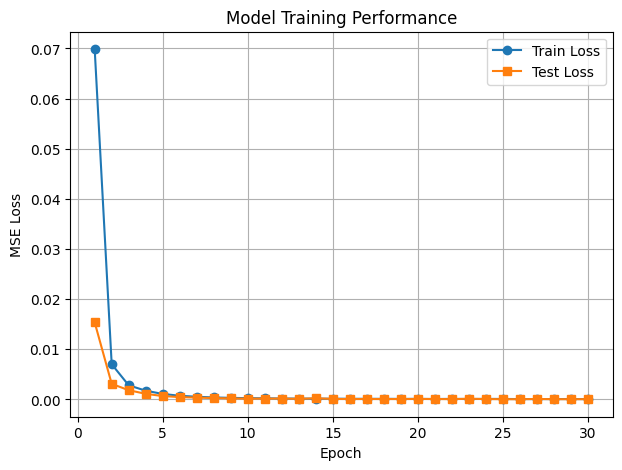

In [7]:
trained_model = main()

In [8]:
# 3) Test on single unseen example
eta_true   = 0.8
gamma_true = 0.5
db_true    = 12.0
eta_pred, gamma_pred = predict_single_example_with_eps(
    trained_model,
    eta_true=eta_true,
    gamma_true=gamma_true,
    db_val=db_true,
    q_pts=28,
    range_q=(-4,4),
    range_p=(-4,4),
    Nphi=5,
    phi_clip=3.0
)
print("\n[Single Example Test]")
print(f"  True   => eta={eta_true:.3f}, gamma={gamma_true:.3f}, dB={db_true:.1f}")
print(f"  Pred   => eta={eta_pred:.3f}, gamma={gamma_pred:.3f}")


[Single Example Test]
  True   => eta=0.800, gamma=0.500, dB=12.0
  Pred   => eta=0.803, gamma=0.500


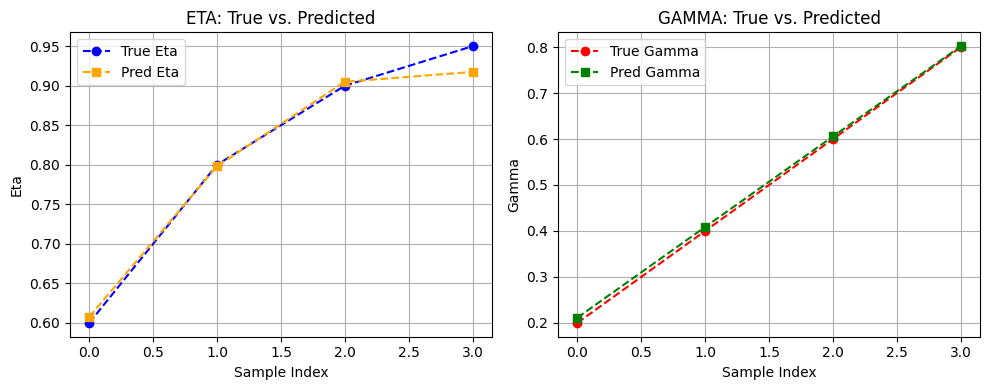

In [9]:
# 4) Test & plot multiple unseen examples
test_triples = [
    (0.6,  0.2, 10.3),
    (0.8,  0.4, 11.1),
    (0.9,  0.6, 13.4),
    (0.95, 0.8, 15.8),
]
plot_prediction_performance_with_eps(
    trained_model,
    test_triples,
    q_pts=28,
    range_q=(-4,4),
    range_p=(-4,4),
    Nphi=5,
    phi_clip=3.0
)